In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Data preparation

In [2]:
functions = [
    lambda x: 5 * x**3 - 2 * x**2 + 3 * x - 17,
    lambda x: np.sin(x) + np.cos(x),
    lambda x: np.log(x + 1),
    lambda x, y: x + 2 * y,
    lambda x, y: np.sin(x / 2) + 2 * np.cos(x),
    lambda x, y: x**2 + 3 * x * y - 7 * y + 1,
]

In [3]:
domains = [
    [(-10, 10), (0, 100), (-1, 1), (-1000, 1000)],
    [(-3.14, 3.14), (0, 7), (0, 100), (-100, 100)],
    [(0, 4), (0, 9), (0, 99), (0, 999)],
    [(0, 1), (-10, 10), (0, 100), (-1000, 1000)],
    [(-3.14, 3.14), (0, 7), (0, 100), (-100, 100)],
    [(-10, 10), (0, 100), (-1, 1), (-1000, 1000)],
]

In [4]:
input_filenames = []

In [5]:
import os
import subprocess

In [6]:
for filename in os.listdir("data\input"):
    os.remove(f"data\input\{filename}")

for i, (function, domains_) in enumerate(zip(functions, domains)):
    if i in [3, 4, 5]:
        continue
    for domain in domains_:
        X = np.linspace(*domain, (n if (n := int(100 * (domain[1] - domain[0])) < 1001) else 1000)).round(2)
        Y = function(X).round(2)
        filename = f"1_{i+1}__{domain[0]}_{domain[1]}.dat"
        with open(f"data\input\{filename}", "a") as f:
            f.write(header := f"1 100 -5 17 {X.shape[0]}\n")
        pd.DataFrame({"X": X, "Y": Y}).to_csv(
            f"data\input\{filename}", index=False, header=False, sep=" ", mode="a"
        )
        input_filenames.append(filename)

In [7]:
input_filenames

['1_1__-10_10.dat',
 '1_1__0_100.dat',
 '1_1__-1_1.dat',
 '1_1__-1000_1000.dat',
 '1_2__-3.14_3.14.dat',
 '1_2__0_7.dat',
 '1_2__0_100.dat',
 '1_2__-100_100.dat',
 '1_3__0_4.dat',
 '1_3__0_9.dat',
 '1_3__0_99.dat',
 '1_3__0_999.dat']

In [8]:
for input_file in input_filenames:
    print(
        command := f"copy NUL data\output\{input_file.split('.')[0] + '.out'} & cd TinyGP & java TinyGP.java ..\data\input\{input_file} > ..\data\output\{input_file.split('.')[0] + '.out'} & cd .."
    )
    t = subprocess.run(command, shell=True, capture_output=True)

copy NUL data\output\1_1__-10_10.out & cd TinyGP & java TinyGP.java ..\data\input\1_1__-10_10.dat > ..\data\output\1_1__-10_10.out & cd ..
copy NUL data\output\1_1__0_100.out & cd TinyGP & java TinyGP.java ..\data\input\1_1__0_100.dat > ..\data\output\1_1__0_100.out & cd ..
copy NUL data\output\1_1__-1_1.out & cd TinyGP & java TinyGP.java ..\data\input\1_1__-1_1.dat > ..\data\output\1_1__-1_1.out & cd ..
copy NUL data\output\1_1__-1000_1000.out & cd TinyGP & java TinyGP.java ..\data\input\1_1__-1000_1000.dat > ..\data\output\1_1__-1000_1000.out & cd ..
copy NUL data\output\1_2__-3.out & cd TinyGP & java TinyGP.java ..\data\input\1_2__-3.14_3.14.dat > ..\data\output\1_2__-3.out & cd ..
copy NUL data\output\1_2__0_7.out & cd TinyGP & java TinyGP.java ..\data\input\1_2__0_7.dat > ..\data\output\1_2__0_7.out & cd ..
copy NUL data\output\1_2__0_100.out & cd TinyGP & java TinyGP.java ..\data\input\1_2__0_100.dat > ..\data\output\1_2__0_100.out & cd ..
copy NUL data\output\1_2__-100_100.out &

### Output parsing

In [ ]:
import re

### Other

In [28]:
X = np.linspace(0, 10, 100)
Y = X**2 + 2

In [29]:
Y_gp = ((-4.647481671744137 + ((-4.647481671744137 + ((0.2169189345053235 / -4.810255309031588) / (((4.990591135490613 / (((1.3011874972913784 - (1.0346911851800469 + ((3.1926749836349853 * -3.6236221002913216) / -1.6857887460556888))) + (0.42640474177373466 / 4.990591135490613)) + (-1.6857887460556888 + -4.5098193029142175))) + 0.8798470532725009) + 1.177191623319274))) - ((3.9065288722705827 * -3.8115014519685273) - (X  * X )))) - ((-3.840963852979363 * -0.3621775125863955) + (-1.1695988886502464 + 3.3461693645531163)))

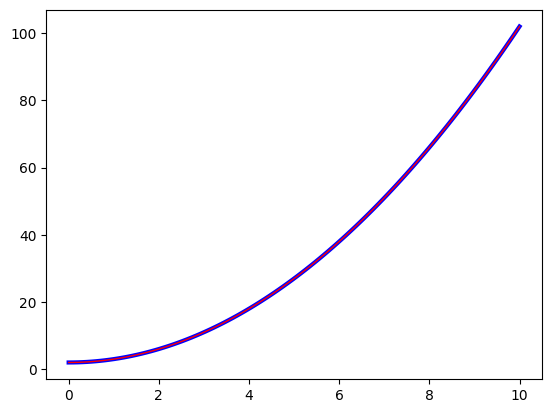

In [32]:
plt.plot(X, Y, 'blue', linewidth=3)
plt.plot(X, Y_gp, 'red', linewidth=1)
plt.show()

# Zad. 1
## Przykład 1
### Dziedzina [-10, 10]

 f(x) = 5*x^3 - 2x^2 + 3x - 17 dziedzina: [-10, 10], [0,100], [-1, 1], [-1000, 1000]

In [25]:
X1 = np.linspace(-10, 10, 200).round(2)
Y1 = 5*X1**3 - 2*X1**2 + 3*X1 - 17
Y1 = Y1.round(2)

In [34]:
Y1_gp = (((((((6.868393009374888 / (((((-3.1702782928387663 * (6.868393009374888 * 13.213267138162522)) - (((((13.50802559751591 * -0.06089973912015445) + (-0.06089973912015445 / (X1  + -2.854554839897281))) * (((13.998320099339857 * (((((16.956553255981945 / (-1.6417000883090664 / (((X1  * ((((((3.3237833060143114 + (3.1742993583182813 + 13.50802559751591)) - ((6.868393009374888 / (((((-3.1702782928387663 * (6.868393009374888 * ((((0.8668476183927236 * 3.6109214532994685) * 11.797615143257971) + 3.1742993583182813) / (14.561068120635188 - ((-0.4447562331900148 - 7.019487553332938) - 8.084613623527344))))) - (((11.797615143257971 * 13.213267138162522) / 15.499961834939537) / (X1  * (X1  * (X1  + -2.854554839897281))))) / ((((-2.5189224317499277 - (((14.561068120635188 + 6.104251789468702) + -1.2266634904126477) - ((-1.7200268660214935 / 6.104251789468702) - 3.573037084732613))) * X1 ) - 9.52715403667498) - ((3.51707967212206 * -4.50349193866276) * (0.3905192747662003 - 8.013310994780312)))) + (((X1  / (16.956553255981945 * 15.524543063601673)) - ((13.434595892020841 + ((X1  / ((15.499961834939537 / ((3.8185647217598166 + ((-1.7530712777588136 + 8.086944267120694) - 9.461821115981863)) - ((X1  * 16.956553255981945) + 6.453509527385975))) + ((X1  - ((16.548900757425898 * X1 ) / -0.06489403947160799)) + 0.8668476183927236))) - (-3.089055389487249 * 3.8185647217598166))) - 13.14384709336127)) - (((-0.5163645502192153 / 8.419212605296323) / 9.429901548616623) - (-4.52392973534729 * ((4.3281333723475655 * X1 ) / ((((((2.1393048953394187 * ((16.034997065992115 - X1 ) - 0.317945603265394)) - (X1  * ((((((8.419212605296323 / X1 ) / (-4.52392973534729 / 2.1393048953394187)) + ((3.811689915032858 * ((-1.7200268660214935 / 6.104251789468702) - 3.573037084732613)) * 16.956553255981945)) * X1 ) / (16.956553255981945 + 9.461821115981863)) * 8.84074083290724))) * ((12.60514789465967 / 3.6109214532994685) * 8.084613623527344)) + (8.84074083290724 * -4.50349193866276)) / (0.8668476183927236 + (-4.50349193866276 + 7.019487553332938))) + X1 )))))) / 2.1393048953394187)) / ((15.499961834939537 / (3.811689915032858 * 3.279943908051779)) + ((X1  - ((16.548900757425898 * X1 ) - -0.06489403947160799)) - 0.8668476183927236)))) / (16.12558042770071 / 16.12558042770071)) - ((X1  / -3.089055389487249) * 16.034997065992115)) * (3.6109214532994685 / 6.868393009374888)) - 9.52715403667498)) + 16.548900757425898) - 2.9991265996182026))) * X1 ) - (((((7.115451006561072 - 13.353222096914664) - (((-2.854554839897281 * (8.084613623527344 / ((-1.7200268660214935 - 11.211839365628933) * 14.461043072165172))) - X1 ) - -4.52392973534729)) + 12.612170149964243) - X1 ) + (16.034997065992115 - (-3.1702782928387663 * (((12.612170149964243 * (15.887374727258194 + ((2.2292872599344937 * ((13.353222096914664 + (X1  + X1 )) - 12.358938345261723)) + ((3.8185647217598166 - -0.24926620464151394) - 13.434595892020841)))) - (16.034997065992115 / ((13.998320099339857 * (0.8668476183927236 * X1 )) * 12.889359540665502))) * 13.213267138162522))))) + -0.5163645502192153) - X1 )) * -1.7530712777588136) * 7.115451006561072)) / 15.499961834939537) / (X1  * (X1  * (X1  + -2.854554839897281))))) / X1 ) + ((13.213267138162522 / 9.429901548616623) - (((-0.5163645502192153 / 8.419212605296323) / 9.429901548616623) - (-4.52392973534729 * ((4.3281333723475655 * X1 ) / ((((8.755973414201366 * ((12.60514789465967 / 3.6109214532994685) * ((((8.086944267120694 - 15.524543063601673) * 3.6109214532994685) + -1.2266634904126477) - 12.358938345261723))) + (8.84074083290724 * -4.50349193866276)) / (0.8668476183927236 + (12.612170149964243 + 7.019487553332938))) + X1 )))))) / 2.1393048953394187)) + ((4.074510655219605 * (X1  + -0.3880340143034404)) * 16.956553255981945)) * X1 ) / (9.041392505282056 + 4.813532052113651)) * X1 ) - (-0.24926620464151394 + 12.839051823028377)) + ((3.51707967212206 * X1 ) + (8.084613623527344 - 13.213267138162522)))

In [41]:
Y1_gp = (((((((6.868393009374888 / (((((-3.1702782928387663 * ((-4.52392973534729 * ((4.3281333723475655 * X1 ) / ((((8.755973414201366 * ((12.60514789465967 / 3.6109214532994685) * (X1  - 12.358938345261723))) + (8.84074083290724 * -4.50349193866276)) / (0.8668476183927236 + (12.612170149964243 + 7.019487553332938))) + X1 ))) * 13.213267138162522)) - (((((13.50802559751591 * -0.06089973912015445) + (-0.06089973912015445 / 12.839051823028377)) * (((13.998320099339857 * (((((16.956553255981945 / (4.3281333723475655 / (((X1  * ((((((-3.1702782928387663 * 14.561068120635188) - 15.499961834939537) / (16.12558042770071 / 16.12558042770071)) - (((-3.1702782928387663 * (6.868393009374888 * 13.213267138162522)) / -3.089055389487249) * 16.034997065992115)) * (3.6109214532994685 / 6.868393009374888)) - 9.52715403667498)) + 16.548900757425898) - 2.9991265996182026))) * X1 ) - (((((((6.104251789468702 / (X1  * -1.7200268660214935)) * ((((((X1  / ((((-3.1702782928387663 + (11.107135646128231 * -0.06089973912015445)) - (((-0.06089973912015445 * ((((((6.868393009374888 / (13.50802559751591 * -0.06089973912015445)) + ((4.074510655219605 * (X1  + -0.3880340143034404)) * 16.956553255981945)) * X1 ) / (9.041392505282056 + 4.813532052113651)) * X1 ) / (X1  + ((14.561068120635188 - ((-1.4717866229229895 - 7.019487553332938) - 8.084613623527344)) - 3.279943908051779)))) / 14.561068120635188) - (13.14384709336127 / ((15.524543063601673 / 9.52715403667498) * 6.453509527385975)))) + ((12.612170149964243 - -1.7530712777588136) - ((12.612170149964243 + (((11.797615143257971 * (0.8668476183927236 - (11.211839365628933 + 8.84074083290724))) + -0.5163645502192153) - ((15.524543063601673 / (((3.279943908051779 + (14.461043072165172 + (-0.4447562331900148 * 8.755973414201366))) - 12.60514789465967) - ((((((9.267288376778504 - ((13.213267138162522 - (((((X1  / 0.8668476183927236) + 16.034997065992115) / ((3.811689915032858 * X1 ) * 4.813532052113651)) + -0.3880340143034404) / 3.1742993583182813)) / X1 )) * X1 ) * X1 ) + ((((((((((((15.524543063601673 / (((X1  * 11.107135646128231) - 3.6109214532994685) * ((12.60514789465967 / 3.6109214532994685) * ((((8.086944267120694 - 15.524543063601673) * 3.6109214532994685) - -1.2266634904126477) - 12.358938345261723)))) + ((3.811689915032858 * X1 ) * 16.956553255981945)) * (4.074510655219605 * (X1  + -0.3880340143034404))) / 12.612170149964243) * X1 ) - ((10.960556940433587 / 0.3905192747662003) + 16.956553255981945)) + (X1  - 7.019487553332938)) * (-0.06089973912015445 - 9.76426438272635)) * ((((((9.041392505282056 - X1 ) + -0.06489403947160799) + ((9.267288376778504 + 2.2292872599344937) * ((0.3905192747662003 - 6.868393009374888) / (((((((6.868393009374888 / ((((((3.6109214532994685 - 12.612170149964243) + (-2.5189224317499277 / ((6.104251789468702 - -4.740888727275066) - -0.3880340143034404))) / ((((6.868393009374888 - 7.019487553332938) + (8.84074083290724 * -4.50349193866276)) + 4.074510655219605) - -0.3880340143034404)) + (((15.524543063601673 - (((((((X1  + (((X1  * (16.956553255981945 * 15.524543063601673)) - 12.358938345261723) - -3.089055389487249)) + ((12.60514789465967 - (((8.755973414201366 + 15.887374727258194) / (X1  * 9.429901548616623)) / 3.8185647217598166)) - 16.816732364340368)) - (16.548900757425898 + X1 )) - 7.019487553332938) * (16.548900757425898 / ((-1.7200268660214935 - 4.813532052113651) * ((-1.4837940166390227 + -0.5163645502192153) - -0.3880340143034404)))) - 9.52715403667498) - -4.52392973534729)) - ((16.548900757425898 * X1 ) / -0.06489403947160799)) - (9.52715403667498 + 14.840212035658325))) / 7.115451006561072) + ((3.811689915032858 * X1 ) * 16.956553255981945))) + ((4.074510655219605 * ((3.6109214532994685 * X1 ) + -0.3880340143034404)) * 16.956553255981945)) * X1 ) / (9.041392505282056 + 4.813532052113651)) * X1 ) - (-0.24926620464151394 + 12.839051823028377)) - -4.52392973534729)))) / (X1  * ((-1.4837940166390227 * 15.524543063601673) + 0.3905192747662003))) + ((3.811689915032858 * X1 ) * 16.956553255981945)) / 11.820253817762762)) * (X1  + ((0.8668476183927236 - 0.3905192747662003) / 16.12558042770071))) * (X1  * X1 )) - (((X1  * ((11.820253817762762 - ((2.1393048953394187 * ((16.034997065992115 - X1 ) - 0.317945603265394)) - (X1  * (6.104251789468702 * 8.84074083290724)))) * (X1  * 8.755973414201366))) / 13.998320099339857) / ((-4.740888727275066 * 4.074510655219605) * (-4.50349193866276 - (((X1  - ((9.461821115981863 - (3.811689915032858 * X1 )) / 13.213267138162522)) * X1 ) + X1 )))))) * 15.524543063601673) + 0.3905192747662003))) + ((3.811689915032858 * X1 ) * (X1  * (X1  * (X1  + -2.854554839897281))))))) - 8.084613623527344))) - 9.470727403316193)) * X1 ) * X1 ) - (((((-2.5189224317499277 - 13.353222096914664) - ((((12.891828409197881 - (((2.2292872599344937 / 9.76426438272635) - 15.524543063601673) - ((-1.7200268660214935 / 4.813532052113651) - 15.524543063601673))) * (8.084613623527344 / ((10.960556940433587 - 11.211839365628933) * 14.461043072165172))) - X1 ) - -4.52392973534729)) + 12.612170149964243) - X1 ) + (16.034997065992115 - 13.14384709336127))) + (16.670647273411248 * ((-3.1702782928387663 * (6.868393009374888 * 13.213267138162522)) - (((((13.50802559751591 * -0.06089973912015445) + (-0.06089973912015445 / 12.839051823028377)) * ((((6.104251789468702 / (X1  * -1.7200268660214935)) * (((((16.956553255981945 / (4.3281333723475655 / (((X1  * X1 ) + 16.548900757425898) - 2.9991265996182026))) * X1 ) - (((((3.811689915032858 * X1 ) - ((X1  - X1 ) - -4.52392973534729)) + 12.612170149964243) - X1 ) + (16.034997065992115 - 13.14384709336127))) + (16.670647273411248 * 3.6109214532994685)) - X1 )) * -1.7530712777588136) * 7.115451006561072)) / 15.499961834939537) / (-0.3880340143034404 * (3.573037084732613 * (X1  + -2.854554839897281))))))) - X1 )) * -1.7530712777588136) - ((((-1.4837940166390227 * 15.524543063601673) * (8.084613623527344 / ((X1  - 11.211839365628933) * 14.461043072165172))) - ((((8.086944267120694 - 15.524543063601673) * 3.6109214532994685) + -1.2266634904126477) - 12.358938345261723)) - X1 )) + 12.612170149964243) - X1 ) + (16.034997065992115 - 13.14384709336127))) + -0.5163645502192153) - X1 )) * -1.7530712777588136) * 7.115451006561072)) / 15.499961834939537) / (X1  * (((11.107135646128231 + 15.499961834939537) - 13.14384709336127) * (X1  + -2.854554839897281))))) / X1 ) + ((12.889359540665502 / ((15.499961834939537 + ((3.8185647217598166 + ((11.820253817762762 + 8.086944267120694) - 9.461821115981863)) - ((-0.5386558817561644 * 16.956553255981945) + 6.453509527385975))) + 12.358938345261723)) - (-3.089055389487249 * 3.8185647217598166))) / 2.1393048953394187)) + ((4.074510655219605 * (X1  + -0.3880340143034404)) * 16.956553255981945)) * X1 ) / (9.041392505282056 + 4.813532052113651)) * X1 ) - (-0.24926620464151394 + 12.839051823028377)) + ((3.51707967212206 * X1 ) + (8.084613623527344 - 13.213267138162522)))

In [26]:
df = pd.DataFrame({'X': X1, 'Y': Y1})
df.to_csv('zad1_1', index=False, header=False, sep=' ')

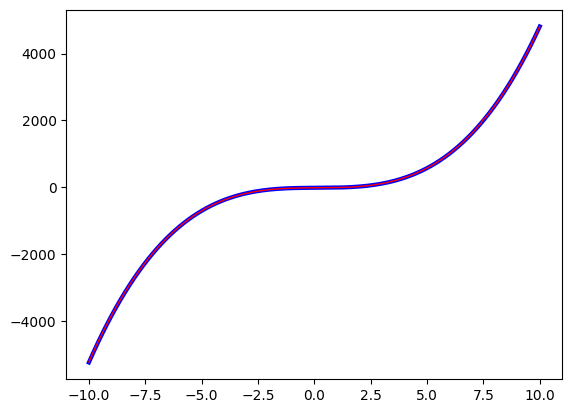

In [42]:
plt.plot(X1, Y1, 'blue', linewidth=3)
plt.plot(X1, Y1_gp, 'red', linewidth=1)

### Dziedzina [0, 100]

In [36]:
X1 = np.linspace(0, 100, 1000).round(2)
Y1 = 5*X1**3 - 2*X1**2 + 3*X1 - 17
Y1 = Y1.round(2)

In [38]:
df = pd.DataFrame({'X': X1, 'Y': Y1})
df.to_csv('zad1_2.dat', index=False, header=False, sep=' ')

In [47]:
Y1_gp = (((((X1  * 4.935193678781239) * X1 ) + 1.2080731695708007) - X1 ) * (X1  + (((6.16072695716935 + X1 ) - 14.382972607279427) / (((-3.306073507420642 * 1.1486479410154207) - 8.62792451802612) - (((-3.1312998016314157 / 13.386572276071664) + (5.1445798079521445 / 10.690559590347714)) * (14.707019217247474 * ((((9.208498429022171 + (-2.360959231372374 - 8.62792451802612)) * 14.836780350102558) + ((11.420603978456743 / (6.033725308335487 * (((((-0.7630679285826485 + ((12.33605253627156 / ((5.330787929302662 - 8.62792451802612) - ((12.289547193455022 + 4.127675824470478) * (((((5.1086788353326895 * X1 ) * (X1  + -3.1312998016314157)) + ((((14.382972607279427 * -1.9899784029178247) * X1 ) + -3.4193620776938247) / ((7.933718938569003 * (X1  * (15.994753401182273 * -0.564673794105909))) - ((1.3756546475836675 * X1 ) * 13.386572276071664)))) * -1.1875598626289792) * (1.3799834961549813 * (7.258805706048175 + ((13.141741938335667 / ((6.518485068459219 - 3.223969313735033) + 11.758936851646592)) + (11.720353930151521 + ((-3.8607284792150107 + 4.63329352251926) / (6.316081281804603 * 1.3799834961549813)))))))))) / (14.342457401092833 - -0.7630679285826485))) + (((X1  - 8.62792451802612) - ((12.289547193455022 + 4.127675824470478) * ((8.69550012844959 * 14.342457401092833) * (1.3799834961549813 * (X1  * -4.324341252765253))))) + (((6.16072695716935 + (11.621565250236078 + (((((((X1  * 4.935193678781239) * X1 ) + (5.330787929302662 - 1.2080731695708007)) - 1.3799834961549813) * (X1  / (8.62792451802612 / ((5.330787929302662 - 8.62792451802612) - (15.994753401182273 + (((14.382972607279427 + 10.615777101839171) * 14.342457401092833) * (1.3756546475836675 * (7.258805706048175 + ((4.58757184858011 / ((((((((14.824068201277328 + 6.064754821978328) - X1 ) + ((4.58757184858011 + (((X1  * 4.935193678781239) * X1 ) + 1.2080731695708007)) - 5.121946028159435)) * ((((X1  * 5.330787929302662) * 0.7510727889738398) * -0.681503760626109) + ((((1.3756546475836675 / 16.889180276862604) + (1.3756546475836675 + (10.690559590347714 / 3.223969313735033))) - 16.029364391781627) * (10.615777101839171 + 3.053369691423052)))) * (12.950559407208878 / 9.208498429022171)) - (4.4361787960431105 * 12.833460123869024)) - 5.131606569441377) + 11.758936851646592)) + 14.707019217247474))))))))) * (((X1  * 8.69550012844959) - -1.1875598626289792) * ((X1  * 8.69550012844959) - 5.131606569441377))) - (14.707019217247474 * 13.89540187408933)))) - (-4.112383863527999 * 0.8581582303462438)) + ((14.836780350102558 * 12.33605253627156) / (14.270567831512121 + -3.444062486179207))))) * X1 ) + 9.422825808830412) + ((16.133977282032134 - 4.4361787960431105) / (X1  * ((((12.289547193455022 / 14.382972607279427) * 11.420603978456743) + (((5.330787929302662 + (14.270567831512121 + X1 )) + 7.933718938569003) * 14.342457401092833)) * 1.1486479410154207)))))) + (6.033725308335487 + -0.681503760626109))) - ((-3.306073507420642 + (((3.053369691423052 / (((-3.4193620776938247 * 1.1486479410154207) + (1.0340100004705146 * 12.339778422064235)) - 6.316081281804603)) / 14.270567831512121) + -3.4193620776938247)) + 12.224013115426732))))))))

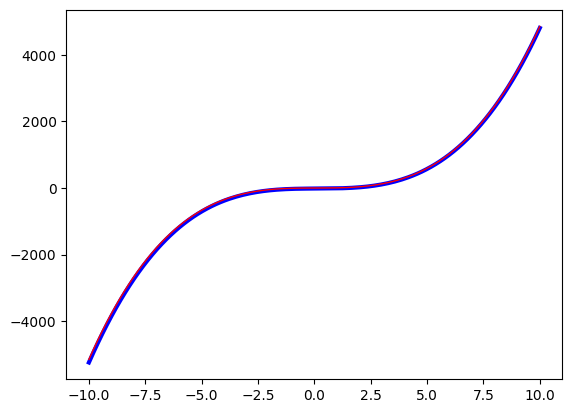

In [48]:
plt.plot(X1, Y1, 'blue', linewidth=3)
plt.plot(X1, Y1_gp, 'red', linewidth=1)

### Dziedzina [-1, 1]